In [1]:
# @title Importing dependencies
import numpy
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np

In [2]:
# @title Downloading MNIST dataset
mnist_train = torchvision.datasets.MNIST('/home/stuti/fods/files/', train=True, download=True,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor()
                            ]))
mnist_test = torchvision.datasets.MNIST('/home/stuti/fods/files/', train=False, download=True,
                            transform=torchvision.transforms.Compose([
                                torchvision.transforms.ToTensor()
                            ]))

In [ ]:
# # @title Binarise MNIST data
# def binarise_mnist(mnist):
#     mnist_bin = []
#     for img, label in mnist:
#         mnist_bin.append((torch.where(img < 0.5, 0.0, 1.0), label))
#     return mnist_bin

In [ ]:
# X_train = binarise_mnist(mnist_train)
# X_test = binarise_mnist(mnist_test)

In [3]:
class CroppedConvolution2D(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: tuple, padding: tuple):
        super(CroppedConvolution2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_height, self.kernel_width = kernel_size
        self.padding = padding
        self.conv = nn.Conv2d(self.in_channels, self.out_channels, kernel_size, padding=self.padding)

    def forward(self, X):
        X = self.conv(X)
        out = X[:, :, 1:-self.kernel_height, :]
        up_shifted_out = X[:, :, :-self.kernel_height-1, :]
        return out, up_shifted_out

In [4]:
class MaskedConvolution2D(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: tuple, padding: tuple, mask_type: str):
        super(MaskedConvolution2D, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_height, self.kernel_width = kernel_size
        self.padding = padding
        self.mask_type = mask_type
        self.conv = nn.Conv2d(self.in_channels, self.out_channels, kernel_size, padding=self.padding)
        self.create_mask()

    def create_mask(self):
        mask = torch.ones(self.kernel_height, self.kernel_width)
        mask[self.kernel_height // 2, self.kernel_width // 2:] = 0
        mask[self.kernel_height // 2 + 1:, :] = 0
        if self.mask_type == 'B':
            mask[self.kernel_height // 2, self.kernel_width // 2] = 1
        self.register_buffer('mask', mask)

    def forward(self, X):
        self.conv.weight.data = self.conv.weight.data * self.mask
        return self.conv(X)

In [5]:
class CausalBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int):
        super(CausalBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        self.vertical_fc = nn.Conv2d(in_channels=in_channels,
                                     out_channels=2*out_channels,
                                     kernel_size=(1, 1))

        self.vertical_conv = CroppedConvolution2D(in_channels=in_channels,
                                                  out_channels=2*out_channels,
                                                  kernel_size=(kernel_size // 2 + 1, kernel_size),
                                                  padding=(kernel_size // 2 + 1, kernel_size // 2))

        self.vertical_to_horizontal = nn.Conv2d(in_channels=2*out_channels,
                                                out_channels=2*out_channels,
                                                kernel_size=(1, 1))

        self.horizontal_conv = MaskedConvolution2D(in_channels=in_channels,
                                                   out_channels=2*out_channels,
                                                   kernel_size=(1, kernel_size),
                                                   padding=(0, kernel_size // 2),
                                                   mask_type='A')

        self.horizontal_fc = MaskedConvolution2D(in_channels=out_channels,
                                                 out_channels=out_channels,
                                                 kernel_size=(1, 1),
                                                 padding=(0, 0),
                                                 mask_type='A')

    def forward(self, X):
        out_vertical_fc = self.vertical_fc(X)
        out_vertical_conv, up_shifted_out_vertical_conv = self.vertical_conv(X)
        out_vertical_to_horizontal = self.vertical_to_horizontal(up_shifted_out_vertical_conv)
        out_vertical = out_vertical_fc + out_vertical_conv
        out_vertical_tanh, out_vertical_sigmoid = torch.split(out_vertical, self.out_channels, dim=1)
        out_vertical = torch.tanh(out_vertical_tanh) * torch.sigmoid(out_vertical_sigmoid)

        out_horizontal_conv = self.horizontal_conv(X)
        out_horizontal = out_horizontal_conv + out_vertical_to_horizontal
        out_horizontal_tanh, out_horizontal_sigmoid = torch.split(out_horizontal, self.out_channels, dim=1)
        out_horizontal = torch.tanh(out_horizontal_tanh) * torch.sigmoid(out_horizontal_sigmoid)
        out_horizontal = self.horizontal_fc(out_horizontal)

        return out_vertical, out_horizontal

In [6]:
class GatedBlock(nn.Module):
    def __init__(self, in_channels: int, out_channels: int, kernel_size: int, latent_dim: int=16):
        super(GatedBlock, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.latent_dim = latent_dim

        self.vertical_fc = nn.Conv2d(in_channels=in_channels,
                                     out_channels=2*out_channels,
                                     kernel_size=(1, 1))

        self.vertical_to_horizontal = MaskedConvolution2D(in_channels=2*out_channels,
                                                          out_channels=2*out_channels,
                                                          kernel_size=(1, 1),
                                                          padding=(0, 0),
                                                          mask_type='B')

        self.vertical_conv = CroppedConvolution2D(in_channels=in_channels,
                                                  out_channels=2*out_channels,
                                                  kernel_size=(kernel_size // 2 + 1, kernel_size),
                                                  padding=(kernel_size // 2 + 1, kernel_size // 2))

        self.horizontal_conv = MaskedConvolution2D(in_channels=in_channels,
                                                   out_channels=2*out_channels,
                                                   kernel_size=(1, kernel_size),
                                                   padding=(0, kernel_size // 2),
                                                   mask_type='B')

        self.horizontal_fc = MaskedConvolution2D(in_channels=out_channels,
                                                 out_channels=out_channels,
                                                 kernel_size=(1, 1),
                                                 padding=(0, 0),
                                                 mask_type='B')

        self.horizontal_skip = MaskedConvolution2D(in_channels=out_channels,
                                                 out_channels=out_channels,
                                                 kernel_size=(1, 1),
                                                 padding=(0, 0),
                                                 mask_type='B')

        self.latent_embedding = nn.Linear(in_features=latent_dim, out_features=2*out_channels)

    def forward(self, X):
        in_vertical, in_horizontal, latent, skip = X['in_vertical'], X['in_horizontal'], X['latent'], X['skip']
        latent_embedding = self.latent_embedding(latent).unsqueeze(2).unsqueeze(3)

        out_vertical_fc = self.vertical_fc(in_vertical)
        out_vertical_conv, up_shifted_out_vertical_conv = self.vertical_conv(in_vertical)
        out_vertical_to_horizontal = self.vertical_to_horizontal(up_shifted_out_vertical_conv)
        out_vertical = out_vertical_fc + out_vertical_conv + latent_embedding
        out_vertical_tanh, out_vertical_sigmoid = torch.split(out_vertical, self.out_channels, dim=1)
        out_vertical = torch.tanh(out_vertical_tanh) * torch.sigmoid(out_vertical_sigmoid)
        out_vertical += in_vertical

        out_horizontal_conv = self.horizontal_conv(in_horizontal)
        out_horizontal = out_horizontal_conv + out_vertical_to_horizontal + latent_embedding
        out_horizontal_tanh, out_horizontal_sigmoid = torch.split(out_horizontal, self.out_channels, dim=1)
        out_horizontal = torch.tanh(out_horizontal_tanh) * torch.sigmoid(out_horizontal_sigmoid)
        skip += self.horizontal_skip(out_horizontal)
        out_horizontal = self.horizontal_fc(out_horizontal)
        out_horizontal += in_horizontal

        return {'in_vertical': out_vertical,
                'in_horizontal': out_horizontal,
                'latent': latent,
                'skip': skip}

In [7]:
class ConditionalGate(nn.Module):
    def __init__(self, latent_dim: int, out_channels: int=32):
        super(ConditionalGate, self).__init__()
        self.latent_dim = latent_dim
        self.out_channels = out_channels

        self.latent_embedding_tanh = nn.Linear(in_features=latent_dim, out_features=out_channels)
        self.latent_embedding_sigmoid = nn.Linear(in_features=latent_dim, out_features=out_channels)

    def forward(self, X, latent_var):
        out_tanh, out_sigmoid = torch.split(X, self.out_channels, dim=1)
        out_tanh = out_tanh + self.latent_embedding_tanh(latent_var).unsqueeze(2).unsqueeze(3)
        out_sigmoid = out_sigmoid + self.latent_embedding_sigmoid(latent_var).unsqueeze(2).unsqueeze(3)
        out = torch.tanh(out_tanh) * torch.sigmoid(out_sigmoid)
        return out

In [8]:
class Encoder(nn.Module):
    def __init__(self, in_channels: int, latent_dim: int):
        super(Encoder, self).__init__()
        self.in_channels = in_channels
        self.latent_dim = latent_dim

        layers = []
        layers.append(nn.Conv2d(in_channels=in_channels, out_channels=32, kernel_size=3, stride=1, padding='same'))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=2, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1, padding='same'))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1))
        layers.append(nn.ReLU())
        layers.append(nn.ZeroPad2d((0, 1, 0,1)))  # Pad 7x7 feature maps to 8x8
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'))
        layers.append(nn.ReLU())
        layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1))
        layers.append(nn.ReLU())
        for _ in range(3):
            layers.append(nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding='same'))
            layers.append(nn.ReLU())
        layers.append(nn.Flatten())
        layers.append(nn.Linear(in_features=1024, out_features=2*latent_dim))
        self.net = nn.Sequential(*layers)

    def reparameterise(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, X):
        out = self.net(X)
        mu, logvar = torch.split(out, self.latent_dim, dim=1)
        z = self.reparameterise(mu, logvar)
        return mu, logvar, z

In [ ]:
# class Decoder(nn.Module):
#     def __init__(self, latent_dim: int, gated_blocks: int):
#         super(Decoder, self).__init__()
#         self.latent_dim = latent_dim

#         self.fc = nn.Linear(in_channels=latent_dim, out_channels=4*4*64)
#         self.conv_1 = nn.Sequential(*[nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1) for _ in range(2)])
#         self.trans_conv_1 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=2)
#         self.conv_2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)
#         self.trans_conv_2 = nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=3, stride=2)
#         self.conv_3 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
#         self.trans_conv_3 = nn.ConvTranspose2d(in_channels=32, out_channels=32, kernel_size=3, stride=2)
#         self.conv_4 = nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3, stride=1)
#         self.pixelcnn_gated_block_1 = GatedBlock(in_channels=32, out_channels=32, kernel_size=(7, 7))
#         self.pixelcnn_gated_blocks = nn.Sequential(*[GatedBlock(in_channels=32, out_channels=32, kernel_size=(5, 5)) for _ in range(gated_blocks)])
#         self.pixelcnn_gate_1 = ...

In [9]:
class ConditionalDecoder(nn.Module):
    def __init__(self, latent_dim: int, in_channels: int=1, hidden_layers: int=5):
        super(ConditionalDecoder, self).__init__()
        self.latent_dim = latent_dim
        self.in_channels = in_channels
        self.hidden_layers = hidden_layers

        self.causal_block = CausalBlock(in_channels=in_channels, out_channels=latent_dim, kernel_size=7)
        self.gated_blocks = nn.Sequential(
            *[GatedBlock(in_channels=latent_dim, out_channels=latent_dim, kernel_size=5, latent_dim=latent_dim) for _ in range(hidden_layers)]
        )
        self.conv_1 = nn.Conv2d(in_channels=latent_dim, out_channels=2*latent_dim, kernel_size=(1, 1))
        self.conditional_gate_1 = ConditionalGate(latent_dim=latent_dim, out_channels=latent_dim)
        self.conv_2 = nn.Conv2d(in_channels=latent_dim, out_channels=2*latent_dim, kernel_size=(1, 1))
        self.conditional_gate_2 = ConditionalGate(latent_dim=latent_dim, out_channels=latent_dim)
        self.conv_3 = nn.Conv2d(in_channels=latent_dim, out_channels=4*in_channels, kernel_size=(1, 1))

    def forward(self, X, latent_var):
        out_vertical, out_horizontal = self.causal_block(X)
        out = self.gated_blocks({'in_vertical': out_vertical,
                                 'in_horizontal': out_horizontal,
                                 'latent': latent_var,
                                 'skip': X.new_zeros(X.size()[0], self.latent_dim, X.size()[2], X.size()[3])})['in_horizontal']
        out = self.conv_1(out)
        out = self.conditional_gate_1(out, latent_var)
        out = self.conv_2(out)
        out = self.conditional_gate_2(out, latent_var)
        out = self.conv_3(out)
        return out

In [10]:
class PixelVAE(nn.Module):
    def __init__(self, in_channels: int, latent_dim: int=32, hidden_layers: int=5):
        super(PixelVAE, self).__init__()
        self.encoder = Encoder(in_channels=in_channels,
                               latent_dim=latent_dim)
        self.decoder = ConditionalDecoder(latent_dim=latent_dim,
                                          in_channels=in_channels,
                                          hidden_layers=hidden_layers)

    def sample(self, image_size: int, num_samples: int, device='cpu'):
        self.eval()

        H, W = image_size
        C = self.decoder.in_channels

        # 1) Sample z ~ N(0, I)
        z = torch.randn(num_samples, self.encoder.latent_dim, device=device)

        # 2) Initialize an empty canvas
        samples = torch.zeros(num_samples, C, H, W, device=device)

        # 3) Raster-scan over pixels: For each position (i, j) and each channel c, ask the decoder for the logits then sample.
        with torch.inference_mode():
            for i in range(H):
                for j in range(W):
                    # decoder expects (x_partial, z) and returns logits [B, C, H, W]
                    logits = self.decoder(samples, z)
                    probs = torch.softmax(logits[:, :, i, j], dim=1)
                    sampled_pixel = torch.multinomial(probs, 1).squeeze(1)
                    samples[:, 0, i, j] = sampled_pixel

        return samples.cpu()

    def forward(self, X):
        mu, logvar, z = self.encoder(X)
        out = self.decoder(X, z)
        return mu, logvar, z, out

In [21]:
# @title Visualising forward passes and sampling of untrained model
torch.manual_seed(42)
model = PixelVAE(in_channels=1,
                 latent_dim=16,
                 hidden_layers=5)
img, label = mnist_train[0]
img = img.unsqueeze(0)
img = torch.clamp((img * 4), max=3)
sample_mu, sample_logvar, sample_z, sample_out = model(img)
img.shape, sample_z.shape, sample_out.shape

(torch.Size([1, 1, 28, 28]), torch.Size([1, 16]), torch.Size([1, 4, 28, 28]))

In [22]:
torch.manual_seed(42)
model = PixelVAE(in_channels=1,
                 latent_dim=16,
                 hidden_layers=5)
img, label = mnist_train[0]
sample = model.sample((28, 28), 1)
img.shape, sample.shape

(torch.Size([1, 28, 28]), torch.Size([1, 1, 28, 28]))

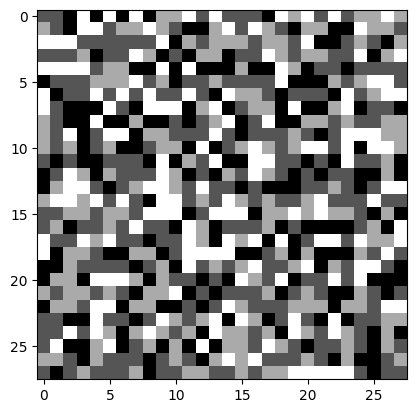

In [23]:
plt.imshow(sample.squeeze().detach().numpy(), cmap='gray')
plt.show()

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [12]:
# @title Creating DataLoader for binarised MNIST
from torch.utils.data import DataLoader

train_loader = DataLoader(mnist_train, batch_size=32, shuffle=True)
test_loader = DataLoader(mnist_test, batch_size=32, shuffle=False)

In [13]:
model = PixelVAE(in_channels=1,
                 latent_dim=128,
                 hidden_layers=15).to(device)
optimiser = torch.optim.Adam(model.parameters(), lr=1e-4)
# scheduler = torch.optim.lr_scheduler.StepLR(optimiser, step_size=10, gamma=0.5)
epochs = 20
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimiser, max_lr=1e-4, total_steps=epochs*len(train_loader),
    pct_start=0.1, anneal_strategy='cos', div_factor=10)

for epoch in range(epochs):
    model.train()
    epoch_reconstruction_loss, epoch_regularisation_loss = 0.0, 0.0

    for imgs, _ in tqdm(train_loader):
        imgs = imgs.to(device)

        optimiser.zero_grad()

        pixel_targets = torch.clamp((imgs * 4).long(), max=3)
        mu, logvar, z, logits = model(pixel_targets.float())

        # Reconstruction: sum over pixels, avg over batch
        reconstruction_loss = F.cross_entropy(logits, pixel_targets.squeeze(1))

        # KL divergence
        regularisation_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()

        loss = reconstruction_loss + regularisation_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimiser.step()

        epoch_reconstruction_loss += reconstruction_loss.item()
        epoch_regularisation_loss += regularisation_loss.item()

    scheduler.step()

    model.eval()
    running_val_loss = 0.0
    with torch.inference_mode():
        for img, _ in test_loader:
            img = img.to(device)
            pixel_targets  = torch.clamp((img * 4).long(), max=3)   # (B,1,H,W)

            mu, logvar, z, logits = model(pixel_targets.float())
            loss = F.cross_entropy(logits, pixel_targets.squeeze(1))
            running_val_loss += loss.item()

    avg_val_loss = running_val_loss / len(test_loader)

    print(f"Epoch {epoch+1}/{epochs} \nRecon: {epoch_reconstruction_loss/len(train_loader)}, "
          f"KL: {epoch_regularisation_loss/len(train_loader)}, Total: {(epoch_reconstruction_loss+epoch_regularisation_loss)/len(train_loader)}, "
          f"Test loss: {avg_val_loss}")
    

100%|██████████| 1875/1875 [03:40<00:00,  8.51it/s]


Epoch 1/20 
Recon: 0.46879093613624573, KL: 0.0018850988735755285, Total: 0.47067603500982125, Test loss: 0.2513661811146112


100%|██████████| 1875/1875 [03:41<00:00,  8.48it/s]


Epoch 2/20 
Recon: 0.2332124849319458, KL: 2.669207751750946e-06, Total: 0.23321515413969754, Test loss: 0.21893773111291587


100%|██████████| 1875/1875 [03:41<00:00,  8.48it/s]


Epoch 3/20 
Recon: 0.21453307015101114, KL: 1.7120584845542908e-06, Total: 0.2145347822094957, Test loss: 0.20768943481361524


100%|██████████| 1875/1875 [03:41<00:00,  8.47it/s]


Epoch 4/20 
Recon: 0.20662190883159637, KL: 1.4450783530871073e-06, Total: 0.20662335390994946, Test loss: 0.202397466181947


100%|██████████| 1875/1875 [03:41<00:00,  8.47it/s]


Epoch 5/20 
Recon: 0.20196910343170166, KL: 1.327448586622874e-06, Total: 0.2019704308802883, Test loss: 0.1981589021012425


100%|██████████| 1875/1875 [03:41<00:00,  8.47it/s]


Epoch 6/20 
Recon: 0.1984420038541158, KL: 1.258404552936554e-06, Total: 0.19844326225866873, Test loss: 0.1952050936679109


100%|██████████| 1875/1875 [03:40<00:00,  8.48it/s]


Epoch 7/20 
Recon: 0.19549123338858287, KL: 1.2277722358703614e-06, Total: 0.19549246116081873, Test loss: 0.19280335530876733


100%|██████████| 1875/1875 [03:41<00:00,  8.48it/s]


Epoch 8/20 
Recon: 0.19304008504549663, KL: 1.190457244714101e-06, Total: 0.19304127550274133, Test loss: 0.19060950676282754


100%|██████████| 1875/1875 [03:41<00:00,  8.48it/s]


Epoch 9/20 
Recon: 0.19090788276195525, KL: 1.1659731467564901e-06, Total: 0.190909048735102, Test loss: 0.18803246076495503


100%|██████████| 1875/1875 [03:41<00:00,  8.48it/s]


Epoch 10/20 
Recon: 0.18887510999043783, KL: 1.1461555957794189e-06, Total: 0.1888762561460336, Test loss: 0.18638535791311783


100%|██████████| 1875/1875 [03:41<00:00,  8.47it/s]


Epoch 11/20 
Recon: 0.18704273737271626, KL: 1.129177212715149e-06, Total: 0.187043866549929, Test loss: 0.1852114600019333


100%|██████████| 1875/1875 [03:41<00:00,  8.48it/s]


Epoch 12/20 
Recon: 0.18547341574033102, KL: 1.1116291085879008e-06, Total: 0.1854745273694396, Test loss: 0.18371865248527772


100%|██████████| 1875/1875 [03:41<00:00,  8.48it/s]


Epoch 13/20 
Recon: 0.18407779653072356, KL: 1.1042277018229166e-06, Total: 0.1840789007584254, Test loss: 0.18197629769770102


100%|██████████| 1875/1875 [03:41<00:00,  8.48it/s]


Epoch 14/20 
Recon: 0.18283889841238657, KL: 1.0840425888697307e-06, Total: 0.18283998245497546, Test loss: 0.1810512676977883


100%|██████████| 1875/1875 [03:41<00:00,  8.47it/s]


Epoch 15/20 
Recon: 0.18171209883689882, KL: 1.0783106088638305e-06, Total: 0.18171317714750768, Test loss: 0.18016552091977847


100%|██████████| 1875/1875 [03:40<00:00,  8.48it/s]


Epoch 16/20 
Recon: 0.18073283513387045, KL: 1.0657146573066712e-06, Total: 0.18073390084852775, Test loss: 0.17896763918498834


100%|██████████| 1875/1875 [03:41<00:00,  8.48it/s]


Epoch 17/20 
Recon: 0.17982728306452433, KL: 1.05980783700943e-06, Total: 0.17982834287236135, Test loss: 0.17829358720550903


100%|██████████| 1875/1875 [03:41<00:00,  8.48it/s]


Epoch 18/20 
Recon: 0.17895832119782765, KL: 1.0495265324910483e-06, Total: 0.17895937072436016, Test loss: 0.17779624404998634


100%|██████████| 1875/1875 [03:41<00:00,  8.48it/s]


Epoch 19/20 
Recon: 0.17826482648849487, KL: 1.0427782932917276e-06, Total: 0.17826586926678817, Test loss: 0.1769415905681281


100%|██████████| 1875/1875 [03:41<00:00,  8.48it/s]


Epoch 20/20 
Recon: 0.17749319543043773, KL: 1.0268052419026694e-06, Total: 0.17749422223567962, Test loss: 0.17629774557515837


In [14]:
# Save trained model
torch.save(model,'pixelvae_4_way_model_epochs_20_v3.pth')

torch.save(optimiser,'pixelvae_4_way_optimiser_epochs_20_v3.pth')

In [17]:
import os
os.environ['TORCH_FORCE_NO_WEIGHTS_ONLY_LOAD'] = '1'

In [24]:
# @title Load trained model

model = PixelVAE(in_channels=1,
                 latent_dim=64,
                 hidden_layers=15)  # Create an instance of your model

model.load_state_dict(torch.load('pixelvae_4_way_model_epochs_5.pth', weights_only=False)) # Load the saved state dictionary
model.to(device)

PixelVAE(
  (encoder): Encoder(
    (net): Sequential(
      (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (1): ReLU()
      (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): ReLU()
      (4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (5): ReLU()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): ReLU()
      (8): ZeroPad2d((0, 1, 0, 1))
      (9): ReLU()
      (10): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (11): ReLU()
      (12): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (13): ReLU()
      (14): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (15): ReLU()
      (16): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (17): ReLU()
      (18): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
      (19): ReLU()
      (20): Flatten(start_dim=1, end_dim

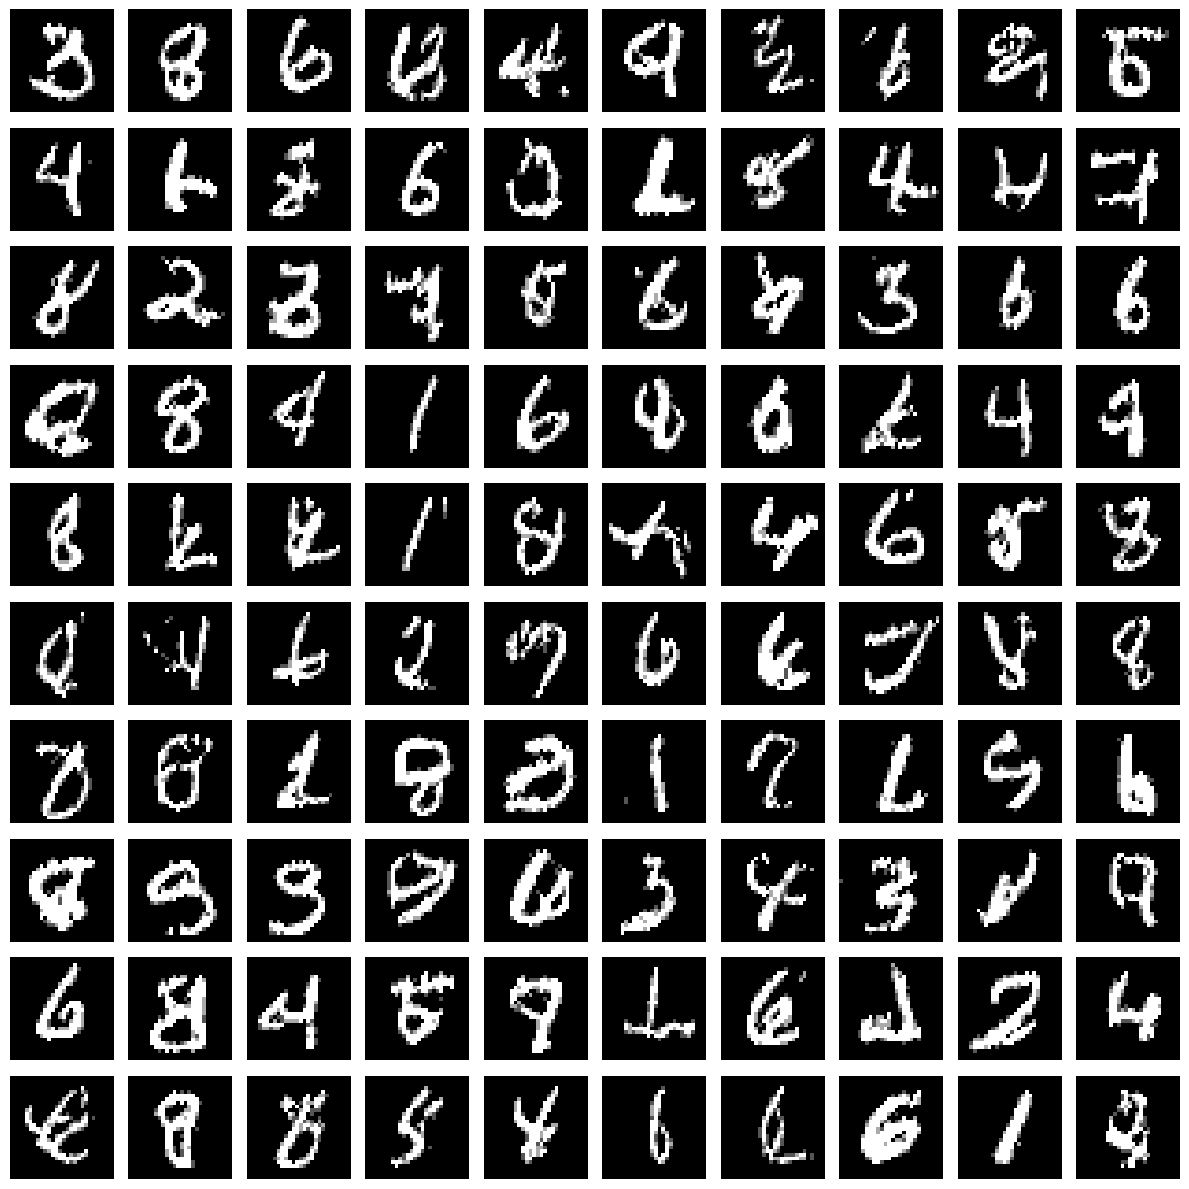

In [15]:
generated_images = model.sample((28, 28), num_samples=100, device=device)

# Plot the 100 images in a 10x10 grid
fig, axes = plt.subplots(10, 10, figsize=(12, 12))
for idx, ax in enumerate(axes.flatten()):
    ax.imshow(generated_images[idx].squeeze(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [16]:
import math
import torch
import torch.nn as nn

def compute_bits_per_dim(model, data_loader, device):
    model.eval()
    total_loss = 0.0
    total_elements = 0
    with torch.inference_mode():
        for imgs, _ in data_loader:
            imgs = imgs.to(device)
            pixel_targets = torch.clamp((imgs * 4).long(), max=3)
            batch_size = imgs.shape[0]
            
            num_pixels = imgs.shape[2] * imgs.shape[3]
            mu, logvar, z, output = model(pixel_targets.float())
            
            loss = F.cross_entropy(output, pixel_targets.squeeze(1), reduction='sum')
            total_loss += loss.item()
            total_elements += batch_size * num_pixels

    
    average_nll = total_loss / total_elements
    
    bits_per_dim = average_nll / math.log(2)
    return average_nll, bits_per_dim

average_nll, bits_dim = compute_bits_per_dim(model, test_loader, device)
print(f"Average NLL (nats per pixel): {average_nll}")
print(f"Bits per dim: {bits_dim}")

Average NLL (nats per pixel): 0.17632228683160275
Bits per dim: 0.2543792888101547
